In [1]:
import numpy as np
import pandas as pd
import nltk
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
import re
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.calibration import CalibratedClassifierCV
from collections import Counter
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
import nltk
nltk.download('wordnet')
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


In [2]:
fake=pd.read_csv('Fake.csv')
real=pd.read_csv('True.csv')

In [3]:
fake['target']=0
real['target']=1
df=pd.concat([fake,real])
df.head()

,title,text,subject,date,target
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [4]:
#combining text and title
df['original'] = df['text'] + ' ' + df['title']
df.head()

,title,text,subject,date,target,original
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0,Donald Trump just couldn t wish all Americans ...
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0,House Intelligence Committee Chairman Devin Nu...
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0,"On Friday, it was revealed that former Milwauk..."
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0,"On Christmas day, Donald Trump announced that ..."
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0,Pope Francis used his annual Christmas Day mes...


In [5]:
def preprocess_text(text_data):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentance in tqdm(text_data):
        sent = sentance.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text

In [6]:
df['original']= preprocess_text(df['original'].values)

100%|██████████████████████████████████████████████████████████████████████████| 44898/44898 [00:07<00:00, 5827.29it/s]


In [7]:
def data_preprocessing(data):
    ###Here we remove all trash in our text
    prep1 = data.lower()
    prep2 = re.sub('https?://\S+|www\.\S+', '', data)
    prep3 = re.sub('\\W', ' ', data)
    prep4 = re.sub('\n', '', data)
    prep5 = re.sub(' +', ' ', data)
    prep6 = re.sub('^ ', '', data)
    prep7 = re.sub(' $', '', data)
    return data

In [8]:
df['original'].apply(data_preprocessing)

0        donald trump just couldn t wish all americans ...
1        house intelligence committee chairman devin nu...
2        on friday it was revealed that former milwauke...
3        on christmas day donald trump announced that h...
4        pope francis used his annual christmas day mes...
                               ...                        
21412    brussels reuters nato allies on tuesday welcom...
21413    london reuters lexisnexis a provider of legal ...
21414    minsk reuters in the shadow of disused soviet ...
21415    moscow reuters vatican secretary of state card...
21416    jakarta reuters indonesia will buy 11 sukhoi f...
Name: original, Length: 44898, dtype: object

In [9]:
lemmatizer = WordNetLemmatizer()
def lemmatization(text):
    lemmas = []
    for word in text.split():
        lemmas.append(lemmatizer.lemmatize(word))
    return " ".join(lemmas)

In [10]:
df['original'].apply(lemmatization)

0        donald trump just couldn t wish all american a...
1        house intelligence committee chairman devin nu...
2        on friday it wa revealed that former milwaukee...
3        on christmas day donald trump announced that h...
4        pope francis used his annual christmas day mes...
                               ...                        
21412    brussels reuters nato ally on tuesday welcomed...
21413    london reuters lexisnexis a provider of legal ...
21414    minsk reuters in the shadow of disused soviet ...
21415    moscow reuters vatican secretary of state card...
21416    jakarta reuters indonesia will buy 11 sukhoi f...
Name: original, Length: 44898, dtype: object

In [11]:
df.head()

,title,text,subject,date,target,original
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0,donald trump just couldn t wish all americans ...
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0,house intelligence committee chairman devin nu...
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0,on friday it was revealed that former milwauke...
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0,on christmas day donald trump announced that h...
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0,pope francis used his annual christmas day mes...


In [12]:
X = df.drop(['title','text','subject','date','target'], axis=1)
Y = df['target'].values

In [13]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.33,stratify=Y)
X_train,X_cv,Y_train,Y_cv=train_test_split(X_train,Y_train,test_size=0.33,stratify=Y_train)
print("X_train shape:",X_train.shape)
print("X_test shape:",X_test.shape)
print("Y_train shape:",Y_train.shape)
print("Y_test shape:",Y_test.shape)
print("X_cv shape:",X_cv.shape)
print("Y_cv shape:",Y_cv.shape)

X_train shape: (20154, 1)
X_test shape: (14817, 1)
Y_train shape: (20154,)
Y_test shape: (14817,)
X_cv shape: (9927, 1)
Y_cv shape: (9927,)


# a.Applying uni-grams

In [19]:
vectorizer = CountVectorizer(ngram_range=(1,1),min_df=10, max_features=5000)
vectorizer.fit(X_train['original'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_bow = vectorizer.transform(X_train['original'].values)
X_cv_essay_bow = vectorizer.transform(X_cv['original'].values)
X_test_essay_bow = vectorizer.transform(X_test['original'].values)

print("After vectorizations")
print("="*100)
print("shape of the matrix of X_train_eassy",X_train_essay_bow.shape, Y_train.shape)
print("shape of the matrix of X_cv_eassy",X_cv_essay_bow.shape, Y_cv.shape)
print("shape of the matrix of X_test_eassy",X_test_essay_bow.shape, Y_test.shape)
print("="*100)

After vectorizations
shape of the matrix of X_train_eassy (20154, 5000) (20154,)
shape of the matrix of X_cv_eassy (9927, 5000) (9927,)
shape of the matrix of X_test_eassy (14817, 5000) (14817,)


# Applying Machine Learning Models

#### a.KNN classifier

In [19]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [0,1]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(6,4))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(6,4))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(6,4))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

In [20]:
#Data preparation for ML models.

#Misc. functionns for ML models


def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [21]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

for alpha = 5
Log Loss : 0.31517417652890783
for alpha = 11
Log Loss : 0.3315864672992267
for alpha = 15
Log Loss : 0.34304591051246963
for alpha = 21
Log Loss : 0.3583104626148284
for alpha = 31
Log Loss : 0.37755429339750934
for alpha = 41
Log Loss : 0.3911244923131716
for alpha = 51
Log Loss : 0.4015292989570809
for alpha = 99
Log Loss : 0.434243019125822


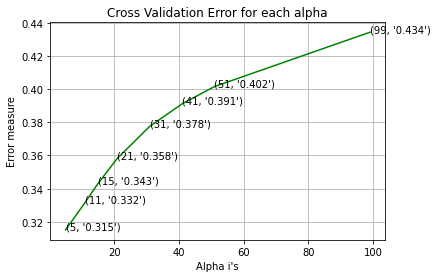

For values of best alpha =  5 The train log loss is: 0.22541938547316856
For values of best alpha =  5 The cross validation log loss is: 0.31517417652890783
For values of best alpha =  5 The test log loss is: 0.3130135450021814


In [25]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(X_train_essay_bow,Y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_essay_bow,Y_train)
    
    sig_clf_probs = sig_clf.predict_proba(X_cv_essay_bow)
    cv_log_error_array.append(log_loss(Y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(Y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(X_train_essay_bow,Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_essay_bow,Y_train)

predict_y = sig_clf.predict_proba(X_train_essay_bow)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_cv_essay_bow)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(Y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_essay_bow)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))


Log loss : 0.31517417652890783
Number of mis-classified points : 0.12269567845270475
-------------------- Confusion matrix --------------------


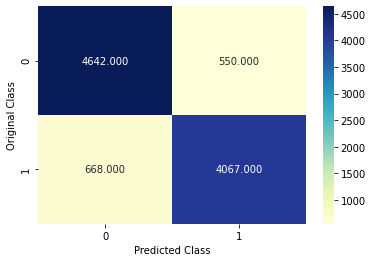

-------------------- Precision matrix (Columm Sum=1) --------------------


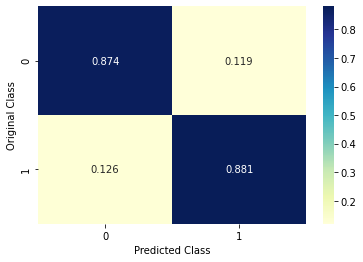

-------------------- Recall matrix (Row sum=1) --------------------


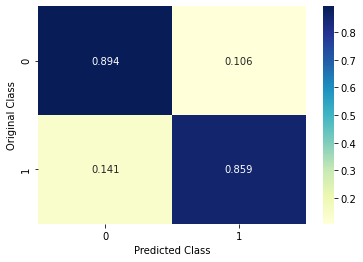

In [28]:
# find more about KNeighborsClassifier() here http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
# -------------------------
# default parameter
# KNeighborsClassifier(n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, p=2, 
# metric=’minkowski’, metric_params=None, n_jobs=1, **kwargs)

# methods of
# fit(X, y) : Fit the model using X as training data and y as target values
# predict(X):Predict the class labels for the provided data
# predict_proba(X):Return probability estimates for the test data X.
#-------------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/k-nearest-neighbors-geometric-intuition-with-a-toy-example-1/
#-------------------------------------
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(X_train_essay_bow,Y_train,X_cv_essay_bow, Y_cv, clf)

#### Query Point

In [29]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(X_train_essay_bow,Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_essay_bow,Y_train)

test_point_index = 678

predicted_cls = sig_clf.predict(X_test_essay_bow[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", Y_test[test_point_index])
neighbors = clf.kneighbors(X_test_essay_bow[test_point_index].reshape(1, -1), alpha[best_alpha])
print("the k value for knn is",alpha[best_alpha],"and the nearest neighbours of the test points belongs to classes",
      Y_train[neighbors[1][0]])
print("Fequency of nearest points :",Counter(Y_train[neighbors[1][0]]))

Predicted Class : 0
Actual Class : 0
the k value for knn is 5 and the nearest neighbours of the test points belongs to classes [0 0 0 0 0]
Fequency of nearest points : Counter({0: 5})


#### b.Naive bayes

for alpha = 1e-05
Log Loss : 0.18143811738054752
for alpha = 0.0001
Log Loss : 0.18381061035672827
for alpha = 0.001
Log Loss : 0.18573487664665317
for alpha = 0.1
Log Loss : 0.19000508083675685
for alpha = 1
Log Loss : 0.19197893377300101
for alpha = 10
Log Loss : 0.19482563232977482
for alpha = 100
Log Loss : 0.20108605990607495
for alpha = 1000
Log Loss : 0.2621938977801726


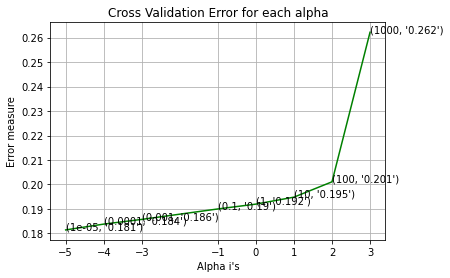

For values of best alpha =  1e-05 The train log loss is: 0.17700184495201393
For values of best alpha =  1e-05 The cross validation log loss is: 0.18143811738054752
For values of best alpha =  1e-05 The test log loss is: 0.17781131201910205


In [30]:
# find more about Multinomial Naive base function here http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
# -------------------------
# default paramters
# sklearn.naive_bayes.MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)

# some of methods of MultinomialNB()
# fit(X, y[, sample_weight])	Fit Naive Bayes classifier according to X, y
# predict(X)	Perform classification on an array of test vectors X.
# predict_log_proba(X)	Return log-probability estimates for the test vector X.
# -----------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/naive-bayes-algorithm-1/
# -----------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
# ----------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/naive-bayes-algorithm-1/
# -----------------------


alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(X_train_essay_bow,Y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_essay_bow,Y_train)
    sig_clf_probs = sig_clf.predict_proba(X_cv_essay_bow)
    cv_log_error_array.append(log_loss(Y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(Y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(X_train_essay_bow,Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_essay_bow,Y_train)


predict_y = sig_clf.predict_proba(X_train_essay_bow)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_cv_essay_bow)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(Y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_essay_bow)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))


Log loss : 0.18143811738054752
Number of mis-classified points : 0.047446358416440015
-------------------- Confusion matrix --------------------


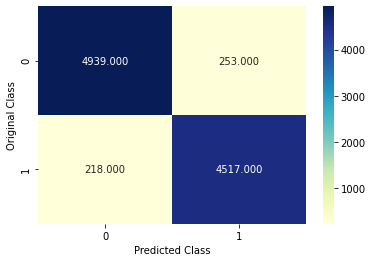

-------------------- Precision matrix (Columm Sum=1) --------------------


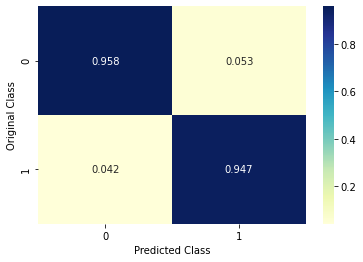

-------------------- Recall matrix (Row sum=1) --------------------


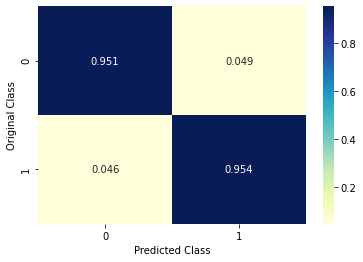

In [31]:
# find more about KNeighborsClassifier() here http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
# -------------------------
# default parameter
# KNeighborsClassifier(n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, p=2, 
# metric=’minkowski’, metric_params=None, n_jobs=1, **kwargs)

# methods of
# fit(X, y) : Fit the model using X as training data and y as target values
# predict(X):Predict the class labels for the provided data
# predict_proba(X):Return probability estimates for the test data X.
#-------------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/k-nearest-neighbors-geometric-intuition-with-a-toy-example-1/
#-------------------------------------
clf = MultinomialNB(alpha=alpha[best_alpha])
predict_and_plot_confusion_matrix(X_train_essay_bow,Y_train,X_cv_essay_bow, Y_cv, clf)

#### Query point

In [32]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(X_train_essay_bow,Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_essay_bow,Y_train)

test_point_index = 4956

predicted_cls = sig_clf.predict(X_test_essay_bow[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", Y_test[test_point_index])

Predicted Class : 1
Actual Class : 1


#### c.Logistic Regression

for alpha = 1e-06
Log Loss : 0.13938829238524608
for alpha = 1e-05
Log Loss : 0.0450873065946947
for alpha = 0.0001
Log Loss : 0.0472500519772786
for alpha = 0.001
Log Loss : 0.04352874923782339
for alpha = 0.01
Log Loss : 0.04642369009542301
for alpha = 0.1
Log Loss : 0.09239778062491633
for alpha = 1
Log Loss : 0.15167706674353976


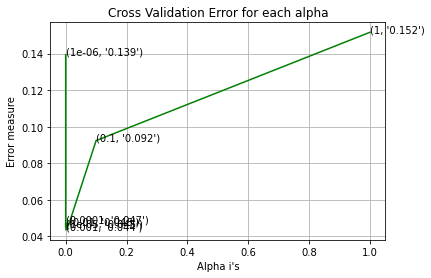

For values of best alpha =  0.001 The train log loss is: 0.02912419218442632
For values of best alpha =  0.001 The cross validation log loss is: 0.04352874923782339
For values of best alpha =  0.001 The test log loss is: 0.04550248470450631


In [33]:
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/geometric-intuition-1/
#------------------------------



# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------

alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train_essay_bow,Y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_essay_bow,Y_train)
    sig_clf_probs = sig_clf.predict_proba(X_cv_essay_bow)
    cv_log_error_array.append(log_loss(Y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(Y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train_essay_bow,Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_essay_bow,Y_train)

predict_y = sig_clf.predict_proba(X_train_essay_bow)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_cv_essay_bow)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(Y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_essay_bow)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 0.04352874923782339
Number of mis-classified points : 0.006648534300392868
-------------------- Confusion matrix --------------------


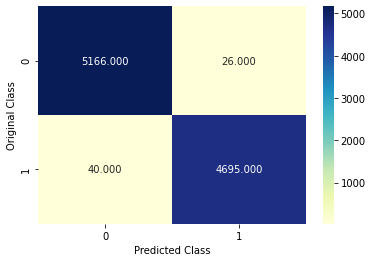

-------------------- Precision matrix (Columm Sum=1) --------------------


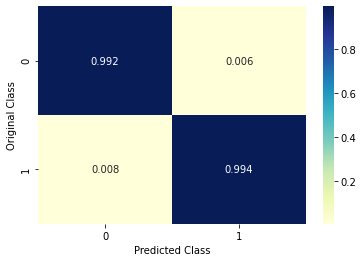

-------------------- Recall matrix (Row sum=1) --------------------


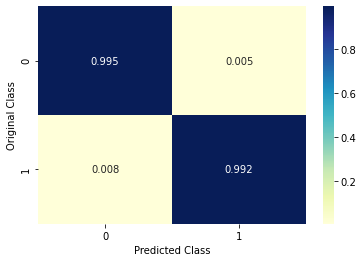

In [34]:
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------

clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(X_train_essay_bow, Y_train,X_cv_essay_bow, Y_cv, clf)

#### Query Point

In [35]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train_essay_bow,Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_essay_bow,Y_train)

test_point_index = 345

predicted_cls = sig_clf.predict(X_test_essay_bow[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", Y_test[test_point_index])

Predicted Class : 0
Actual Class : 0


#### d.SVC

for C = 1e-05
Log Loss : 0.048106130354283405
for C = 0.0001
Log Loss : 0.045154322770802585
for C = 0.001
Log Loss : 0.04405675755120761
for C = 0.01
Log Loss : 0.041868529803379934
for C = 0.1
Log Loss : 0.0534300740215532
for C = 1
Log Loss : 0.11112379522033523
for C = 10
Log Loss : 0.18544897115236228
for C = 100
Log Loss : 0.4429354119794527


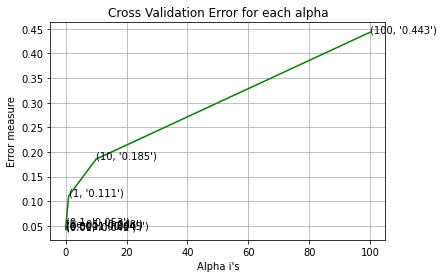

For values of best alpha =  0.01 The train log loss is: 0.026711012474095568
For values of best alpha =  0.01 The cross validation log loss is: 0.041868529803379934
For values of best alpha =  0.01 The test log loss is: 0.04342352521409477


In [36]:
# read more about support vector machines with linear kernals here http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

# --------------------------------
# default parameters 
# SVC(C=1.0, kernel=’rbf’, degree=3, gamma=’auto’, coef0=0.0, shrinking=True, probability=False, tol=0.001, 
# cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=’ovr’, random_state=None)

# Some of methods of SVM()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/mathematical-derivation-copy-8/
# --------------------------------



# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------

alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(X_train_essay_bow,Y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_essay_bow,Y_train)
    sig_clf_probs = sig_clf.predict_proba(X_cv_essay_bow)
    cv_log_error_array.append(log_loss(Y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(Y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(X_train_essay_bow,Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_essay_bow,Y_train)

predict_y = sig_clf.predict_proba(X_train_essay_bow)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_cv_essay_bow)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(Y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_essay_bow)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 0.041525046394008655
Number of mis-classified points : 0.005439709882139619
-------------------- Confusion matrix --------------------


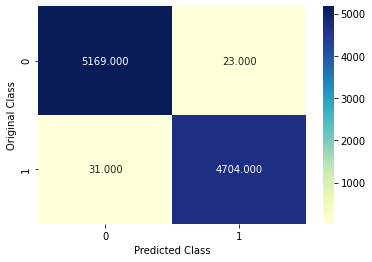

-------------------- Precision matrix (Columm Sum=1) --------------------


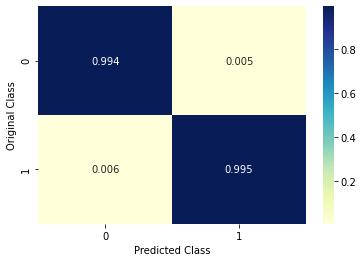

-------------------- Recall matrix (Row sum=1) --------------------


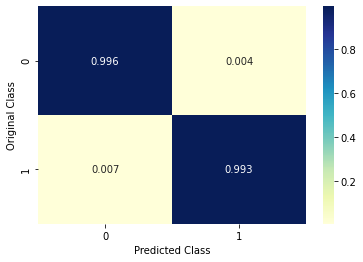

In [37]:
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------

clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(X_train_essay_bow, Y_train,X_cv_essay_bow, Y_cv, clf)

#### Query Point

In [38]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(X_train_essay_bow,Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_essay_bow,Y_train)

test_point_index = 1500

predicted_cls = sig_clf.predict(X_test_essay_bow[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", Y_test[test_point_index])

Predicted Class : 0
Actual Class : 0


#### e.Random Forest Classifier

for n_estimators = 100 and max depth =  5
Log Loss : 0.07964989725608572
for n_estimators = 100 and max depth =  10
Log Loss : 0.03595382739554583
for n_estimators = 200 and max depth =  5
Log Loss : 0.0737631155947572
for n_estimators = 200 and max depth =  10
Log Loss : 0.03332569004104988
for n_estimators = 500 and max depth =  5
Log Loss : 0.06254170261817643
for n_estimators = 500 and max depth =  10
Log Loss : 0.030855044944875922
for n_estimators = 1000 and max depth =  5
Log Loss : 0.0585074870589039
for n_estimators = 1000 and max depth =  10
Log Loss : 0.029560198135162707
for n_estimators = 2000 and max depth =  5
Log Loss : 0.05661880302765788
for n_estimators = 2000 and max depth =  10
Log Loss : 0.028083968231751785


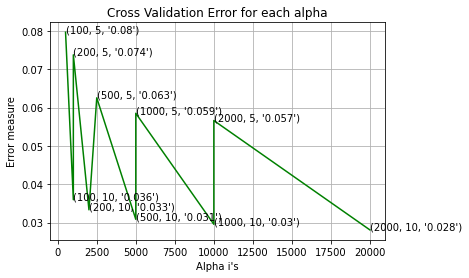

For values of best estimator =  2000 The train log loss is: 0.01508056632304784
For values of best estimator =  2000 The cross validation log loss is: 0.028083968231751785
For values of best estimator =  2000 The test log loss is: 0.03344339021973047


In [39]:
# --------------------------------
# default parameters 
# sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, 
# class_weight=None)

# Some of methods of RandomForestClassifier()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# predict_proba (X)	Perform classification on samples in X.

# some of attributes of  RandomForestClassifier()
# feature_importances_ : array of shape = [n_features]
# The feature importances (the higher, the more important the feature).

# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/random-forest-and-their-construction-2/
# --------------------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------

alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(X_train_essay_bow,Y_train)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(X_train_essay_bow,Y_train)
        sig_clf_probs = sig_clf.predict_proba(X_cv_essay_bow)
        cv_log_error_array.append(log_loss(Y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(Y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/2)],max_depth[int(i%2)],str(txt)), (features[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(X_train_essay_bow,Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_essay_bow,Y_train)

predict_y = sig_clf.predict_proba(X_train_essay_bow)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_cv_essay_bow)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(Y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_essay_bow)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 0.028083968231751785
Number of mis-classified points : 0.010073536818777073
-------------------- Confusion matrix --------------------


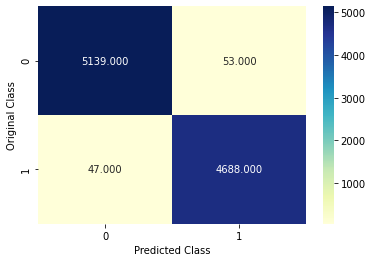

-------------------- Precision matrix (Columm Sum=1) --------------------


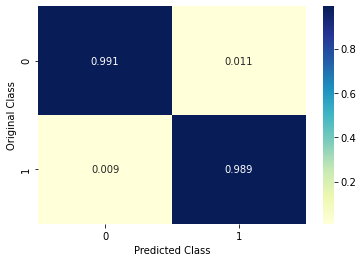

-------------------- Recall matrix (Row sum=1) --------------------


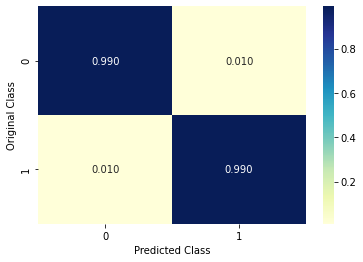

In [40]:
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------

clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], 
                             random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(X_train_essay_bow, Y_train,X_cv_essay_bow, Y_cv, clf)

#### Query Point

In [41]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(X_train_essay_bow,Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_essay_bow,Y_train)

test_point_index = 178

predicted_cls = sig_clf.predict(X_test_essay_bow[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", Y_test[test_point_index])

Predicted Class : 0
Actual Class : 0


#### f.XGBoost Classifier

log_loss for c =  10 is 0.01921443354307794
log_loss for c =  50 is 0.016843640332310374
log_loss for c =  100 is 0.012224685578355914
log_loss for c =  500 is 0.011379802864480103
log_loss for c =  1000 is 0.011812785419338142
log_loss for c =  2000 is 0.011932695420467071


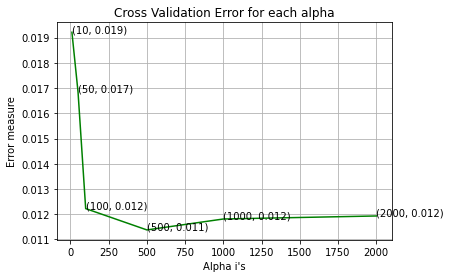

For values of best alpha =  500 The train log loss is: 0.003687440869370231
For values of best alpha =  500 The cross validation log loss is: 0.011379802864480103
For values of best alpha =  500 The test log loss is: 0.016665515822703553


In [42]:
# Training a hyper-parameter tuned Xg-Boost regressor on our train data

# find more about XGBClassifier function here http://xgboost.readthedocs.io/en/latest/python/python_api.html?#xgboost.XGBClassifier
# -------------------------
# default paramters
# class xgboost.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, 
# objective='binary:logistic', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, 
# max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
# scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, **kwargs)

# some of methods of RandomForestRegressor()
# fit(X, y, sample_weight=None, eval_set=None, eval_metric=None, early_stopping_rounds=None, verbose=True, xgb_model=None)
# get_params([deep])	Get parameters for this estimator.
# predict(data, output_margin=False, ntree_limit=0) : Predict with data. NOTE: This function is not thread safe.
# get_score(importance_type='weight') -> get the feature importance
# -----------------------
# video link1: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/regression-using-decision-trees-2/
# video link2: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/what-are-ensembles/
# -----------------------

alpha=[10,50,100,500,1000,2000]
cv_log_error_array=[]
for i in alpha:
    x_cfl=XGBClassifier(n_estimators=i,nthread=-1)
    x_cfl.fit(X_train_essay_bow,Y_train)
    sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
    sig_clf.fit(X_train_essay_bow,Y_train)
    predict_y = sig_clf.predict_proba(X_cv_essay_bow)
    cv_log_error_array.append(log_loss(Y_cv, predict_y, labels=x_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

x_cfl=XGBClassifier(n_estimators=alpha[best_alpha],nthread=-1)
x_cfl.fit(X_train_essay_bow,Y_train)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(X_train_essay_bow,Y_train)
    
predict_y = sig_clf.predict_proba(X_train_essay_bow)
print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_train, predict_y))
predict_y = sig_clf.predict_proba(X_cv_essay_bow)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(Y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test_essay_bow)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_y))

Log loss : 0.011379802864480103
Number of mis-classified points : 0.001813236627379873
-------------------- Confusion matrix --------------------


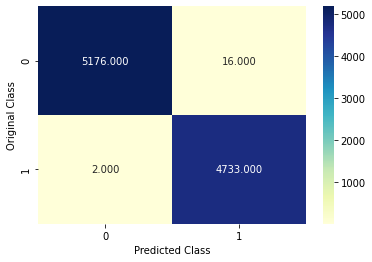

-------------------- Precision matrix (Columm Sum=1) --------------------


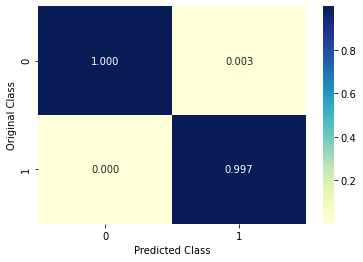

-------------------- Recall matrix (Row sum=1) --------------------


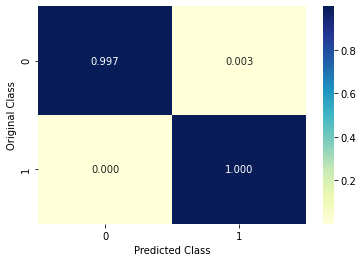

In [43]:
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------

clf = XGBClassifier(n_estimators=alpha[best_alpha],random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(X_train_essay_bow, Y_train,X_cv_essay_bow, Y_cv, clf)

#### XgBoost Classification with best hyper parameters using RandomSearch

In [44]:
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
x_cfl=XGBClassifier()
prams={'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2]}
random_cfl1=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1,)
random_cfl1.fit(X_train_essay_bow,Y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  4.4min finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid=

In [45]:
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
x_cfl=XGBClassifier()
prams={'max_depth':[3,5,10]}
random_cfl2=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1,)
random_cfl2.fit(X_train_essay_bow,Y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  3.9min finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid=

In [46]:
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
x_cfl=XGBClassifier()
prams={'n_estimators':[100,200,500,1000,2000]}
random_cfl3=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1,)
random_cfl3.fit(X_train_essay_bow,Y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 15.4min
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 23.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 23.0min finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid=

In [47]:
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
x_cfl=XGBClassifier()
prams={'colsample_bytree':[0.1,0.3,0.5,1]}
random_cfl4=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1,)
random_cfl4.fit(X_train_essay_bow,Y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   54.1s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.7min finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid=

In [48]:
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
x_cfl=XGBClassifier()
prams={'subsample':[0.1,0.3,0.5,1]}
random_cfl5=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1,)
random_cfl5.fit(X_train_essay_bow,Y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  3.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  3.0min finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid=

In [49]:
print(random_cfl1.best_params_)
print(random_cfl2.best_params_)
print(random_cfl3.best_params_)
print(random_cfl4.best_params_)
print(random_cfl5.best_params_)

{'learning_rate': 0.2}
{'max_depth': 5}
{'n_estimators': 1000}
{'colsample_bytree': 0.3}
{'subsample': 1}


train loss 0.0032764439135322325
cv loss 0.011800583545452154
test loss 0.016165978836514334
Log loss : 0.011800583545452154
Number of mis-classified points : 0.0020147073637554144
-------------------- Confusion matrix --------------------


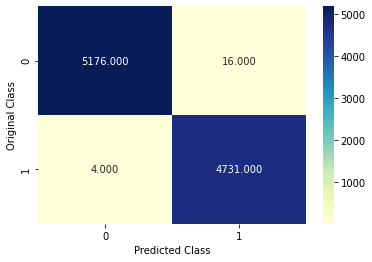

-------------------- Precision matrix (Columm Sum=1) --------------------


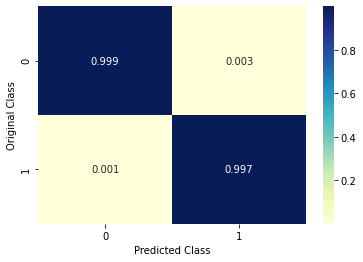

-------------------- Recall matrix (Row sum=1) --------------------


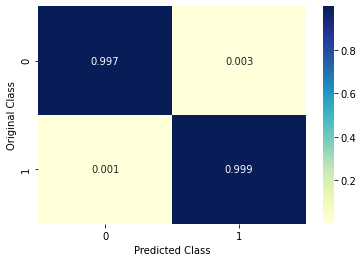

In [50]:
x_cfl=XGBClassifier(n_estimators=1000, learning_rate=0.2, colsample_bytree=0.3, max_depth=5,subsample=1)
x_cfl.fit(X_train_essay_bow,Y_train)
c_cfl=CalibratedClassifierCV(x_cfl,method='sigmoid')
c_cfl.fit(X_train_essay_bow,Y_train)

predict_y = c_cfl.predict_proba(X_train_essay_bow)
print ('train loss',log_loss(Y_train, predict_y))
predict_y = c_cfl.predict_proba(X_cv_essay_bow)
print ('cv loss',log_loss(Y_cv, predict_y))
predict_y = c_cfl.predict_proba(X_test_essay_bow)
print ('test loss',log_loss(Y_test, predict_y))
predict_and_plot_confusion_matrix(X_train_essay_bow, Y_train,X_cv_essay_bow, Y_cv, x_cfl)

#### Query Point

In [51]:
clf=XGBClassifier(n_estimators=1000, learning_rate=0.2, colsample_bytree=0.3, max_depth=5,subsample=1)
clf.fit(X_train_essay_bow,Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_essay_bow,Y_train)

test_point_index = 4678

predicted_cls = sig_clf.predict(X_test_essay_bow[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", Y_test[test_point_index])

Predicted Class : 1
Actual Class : 1


# b.Applying Bi-grams

In [15]:
vectorizer = CountVectorizer(ngram_range=(2,2),min_df=10, max_features=5500)
vectorizer.fit(X_train['original'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_bow_bi = vectorizer.transform(X_train['original'].values)
X_cv_essay_bow_bi = vectorizer.transform(X_cv['original'].values)
X_test_essay_bow_bi = vectorizer.transform(X_test['original'].values)

print("After vectorizations")
print("="*100)
print("shape of the matrix of X_train_eassy",X_train_essay_bow_bi.shape, Y_train.shape)
print("shape of the matrix of X_cv_eassy",X_cv_essay_bow_bi.shape, Y_cv.shape)
print("shape of the matrix of X_test_eassy",X_test_essay_bow_bi.shape, Y_test.shape)

After vectorizations
shape of the matrix of X_train_eassy (20154, 5500) (20154,)
shape of the matrix of X_cv_eassy (9927, 5500) (9927,)
shape of the matrix of X_test_eassy (14817, 5500) (14817,)


# Applying Machine Learning Models

#### a.KNN Classifier

for alpha = 5
Log Loss : 0.5557544760059839
for alpha = 11
Log Loss : 0.578056641983105
for alpha = 15
Log Loss : 0.5883770167723563
for alpha = 21
Log Loss : 0.5998979318612687
for alpha = 31
Log Loss : 0.6121807468427776
for alpha = 41
Log Loss : 0.619582363925453
for alpha = 51
Log Loss : 0.6245870983465152
for alpha = 99
Log Loss : 0.6369528256463515


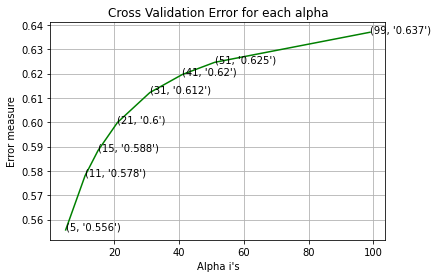

For values of best alpha =  5 The train log loss is: 0.4548100666284787
For values of best alpha =  5 The cross validation log loss is: 0.5557544760059839
For values of best alpha =  5 The test log loss is: 0.550825712078276


In [64]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(X_train_essay_bow_bi,Y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_essay_bow_bi,Y_train)
    
    sig_clf_probs = sig_clf.predict_proba(X_cv_essay_bow_bi)
    cv_log_error_array.append(log_loss(Y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(Y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(X_train_essay_bow_bi,Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_essay_bow_bi,Y_train)

predict_y = sig_clf.predict_proba(X_train_essay_bow_bi)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_cv_essay_bow_bi)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(Y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_essay_bow_bi)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))


Log loss : 0.5557544760059839
Number of mis-classified points : 0.28236123703032134
-------------------- Confusion matrix --------------------


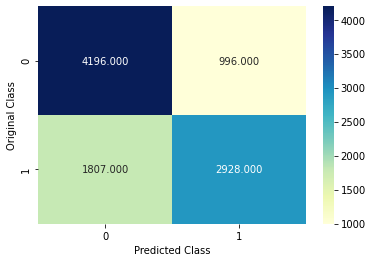

-------------------- Precision matrix (Columm Sum=1) --------------------


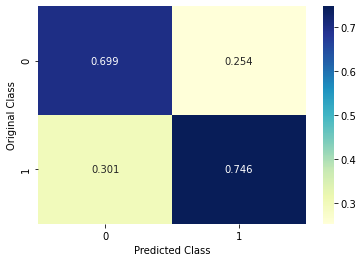

-------------------- Recall matrix (Row sum=1) --------------------


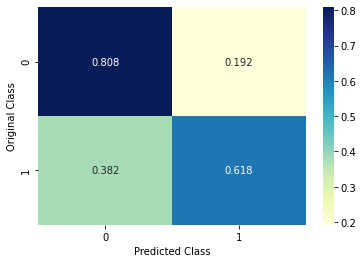

In [65]:
# find more about KNeighborsClassifier() here http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
# -------------------------
# default parameter
# KNeighborsClassifier(n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, p=2, 
# metric=’minkowski’, metric_params=None, n_jobs=1, **kwargs)

# methods of
# fit(X, y) : Fit the model using X as training data and y as target values
# predict(X):Predict the class labels for the provided data
# predict_proba(X):Return probability estimates for the test data X.
#-------------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/k-nearest-neighbors-geometric-intuition-with-a-toy-example-1/
#-------------------------------------
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(X_train_essay_bow_bi,Y_train,X_cv_essay_bow_bi, Y_cv, clf)

#### Query Point

In [66]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(X_train_essay_bow_bi,Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_essay_bow_bi,Y_train)

test_point_index = 560

predicted_cls = sig_clf.predict(X_test_essay_bow_bi[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", Y_test[test_point_index])
neighbors = clf.kneighbors(X_test_essay_bow_bi[test_point_index].reshape(1, -1), alpha[best_alpha])
print("the k value for knn is",alpha[best_alpha],"and the nearest neighbours of the test points belongs to classes",
      Y_train[neighbors[1][0]])
print("Fequency of nearest points :",Counter(Y_train[neighbors[1][0]]))

Predicted Class : 0
Actual Class : 0
the k value for knn is 5 and the nearest neighbours of the test points belongs to classes [0 0 0 0 0]
Fequency of nearest points : Counter({0: 5})


#### b.Naive bayes

for alpha = 1e-05
Log Loss : 0.12037895109462086
for alpha = 0.0001
Log Loss : 0.12199024312654785
for alpha = 0.001
Log Loss : 0.1248673790594987
for alpha = 0.1
Log Loss : 0.1307248303132237
for alpha = 1
Log Loss : 0.13574726661927536
for alpha = 10
Log Loss : 0.146072307477347
for alpha = 100
Log Loss : 0.15240059911537318
for alpha = 1000
Log Loss : 0.15556420320316852


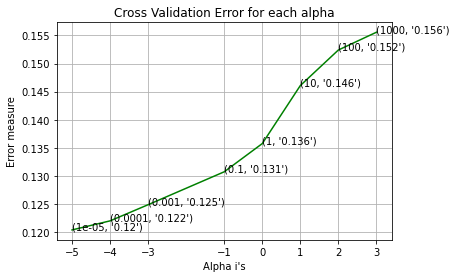

For values of best alpha =  1e-05 The train log loss is: 0.11551507624365477
For values of best alpha =  1e-05 The cross validation log loss is: 0.12037895109462086
For values of best alpha =  1e-05 The test log loss is: 0.12932603884890445


In [67]:
# find more about Multinomial Naive base function here http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
# -------------------------
# default paramters
# sklearn.naive_bayes.MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)

# some of methods of MultinomialNB()
# fit(X, y[, sample_weight])	Fit Naive Bayes classifier according to X, y
# predict(X)	Perform classification on an array of test vectors X.
# predict_log_proba(X)	Return log-probability estimates for the test vector X.
# -----------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/naive-bayes-algorithm-1/
# -----------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
# ----------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/naive-bayes-algorithm-1/
# -----------------------


alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(X_train_essay_bow_bi,Y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_essay_bow_bi,Y_train)
    sig_clf_probs = sig_clf.predict_proba(X_cv_essay_bow_bi)
    cv_log_error_array.append(log_loss(Y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(Y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(X_train_essay_bow_bi,Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_essay_bow_bi,Y_train)


predict_y = sig_clf.predict_proba(X_train_essay_bow_bi)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_cv_essay_bow_bi)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(Y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_essay_bow_bi)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))


Log loss : 0.12037895109462086
Number of mis-classified points : 0.02941472751082905
-------------------- Confusion matrix --------------------


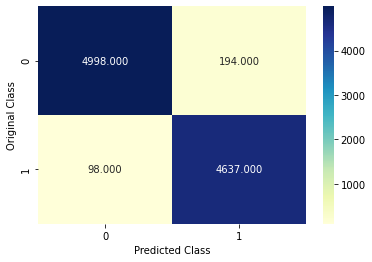

-------------------- Precision matrix (Columm Sum=1) --------------------


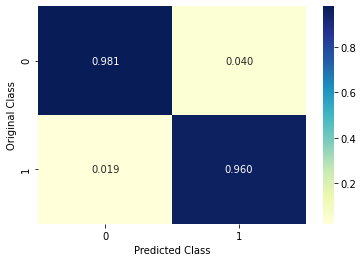

-------------------- Recall matrix (Row sum=1) --------------------


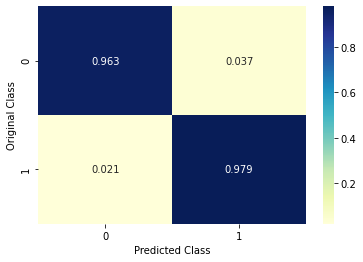

In [68]:
# find more about KNeighborsClassifier() here http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
# -------------------------
# default parameter
# KNeighborsClassifier(n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, p=2, 
# metric=’minkowski’, metric_params=None, n_jobs=1, **kwargs)

# methods of
# fit(X, y) : Fit the model using X as training data and y as target values
# predict(X):Predict the class labels for the provided data
# predict_proba(X):Return probability estimates for the test data X.
#-------------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/k-nearest-neighbors-geometric-intuition-with-a-toy-example-1/
#-------------------------------------
clf = MultinomialNB(alpha=alpha[best_alpha])
predict_and_plot_confusion_matrix(X_train_essay_bow_bi,Y_train,X_cv_essay_bow_bi, Y_cv, clf)

#### Query Point

In [69]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(X_train_essay_bow_bi,Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_essay_bow_bi,Y_train)

test_point_index = 999

predicted_cls = sig_clf.predict(X_test_essay_bow_bi[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", Y_test[test_point_index])

Predicted Class : 0
Actual Class : 0


#### c.Logistic Regression

for alpha = 1e-06
Log Loss : 0.0643561086981402
for alpha = 1e-05
Log Loss : 0.06410229324331157
for alpha = 0.0001
Log Loss : 0.06255170008778663
for alpha = 0.001
Log Loss : 0.06129181214685578
for alpha = 0.01
Log Loss : 0.08099918811823716
for alpha = 0.1
Log Loss : 0.12320454007266814
for alpha = 1
Log Loss : 0.179233273008438


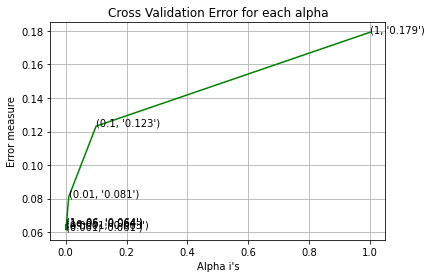

For values of best alpha =  0.001 The train log loss is: 0.0297960459155565
For values of best alpha =  0.001 The cross validation log loss is: 0.06129181214685578
For values of best alpha =  0.001 The test log loss is: 0.06477707397850073


In [70]:
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/geometric-intuition-1/
#------------------------------



# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------

alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train_essay_bow_bi,Y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_essay_bow_bi,Y_train)
    sig_clf_probs = sig_clf.predict_proba(X_cv_essay_bow_bi)
    cv_log_error_array.append(log_loss(Y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(Y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train_essay_bow_bi,Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_essay_bow_bi,Y_train)

predict_y = sig_clf.predict_proba(X_train_essay_bow_bi)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_cv_essay_bow_bi)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(Y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_essay_bow_bi)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 0.06129181214685578
Number of mis-classified points : 0.013297068600785736
-------------------- Confusion matrix --------------------


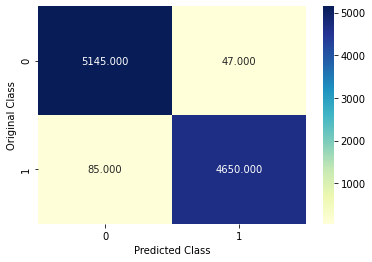

-------------------- Precision matrix (Columm Sum=1) --------------------


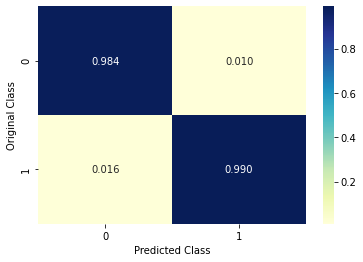

-------------------- Recall matrix (Row sum=1) --------------------


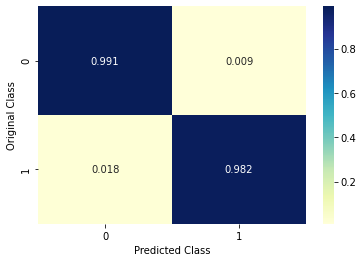

In [71]:
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------

clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(X_train_essay_bow_bi, Y_train,X_cv_essay_bow_bi, Y_cv, clf)

#### Query Point

In [72]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train_essay_bow_bi,Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_essay_bow_bi,Y_train)

test_point_index = 1999

predicted_cls = sig_clf.predict(X_test_essay_bow_bi[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", Y_test[test_point_index])

Predicted Class : 1
Actual Class : 1


#### d.SVC

for C = 1e-05
Log Loss : 0.06350784188510426
for C = 0.0001
Log Loss : 0.061431634446629475
for C = 0.001
Log Loss : 0.0624507833778968
for C = 0.01
Log Loss : 0.06305396433561407
for C = 0.1
Log Loss : 0.09229530742536596
for C = 1
Log Loss : 0.14758625178058477
for C = 10
Log Loss : 0.277968576500688
for C = 100
Log Loss : 0.3612373225267524


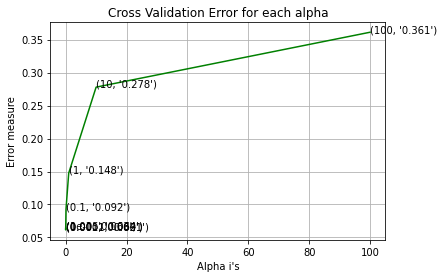

For values of best alpha =  0.0001 The train log loss is: 0.030670874777921
For values of best alpha =  0.0001 The cross validation log loss is: 0.061431634446629475
For values of best alpha =  0.0001 The test log loss is: 0.06370331528547045


In [73]:
# read more about support vector machines with linear kernals here http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

# --------------------------------
# default parameters 
# SVC(C=1.0, kernel=’rbf’, degree=3, gamma=’auto’, coef0=0.0, shrinking=True, probability=False, tol=0.001, 
# cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=’ovr’, random_state=None)

# Some of methods of SVM()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/mathematical-derivation-copy-8/
# --------------------------------



# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------

alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(X_train_essay_bow_bi,Y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_essay_bow_bi,Y_train)
    sig_clf_probs = sig_clf.predict_proba(X_cv_essay_bow_bi)
    cv_log_error_array.append(log_loss(Y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(Y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(X_train_essay_bow_bi,Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_essay_bow_bi,Y_train)

predict_y = sig_clf.predict_proba(X_train_essay_bow_bi)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_cv_essay_bow_bi)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(Y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_essay_bow_bi)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 0.06333311329892571
Number of mis-classified points : 0.016419865014606627
-------------------- Confusion matrix --------------------


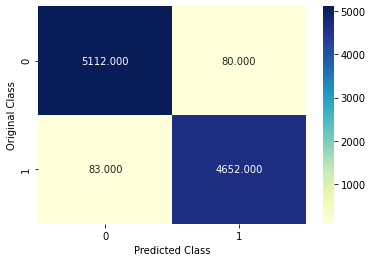

-------------------- Precision matrix (Columm Sum=1) --------------------


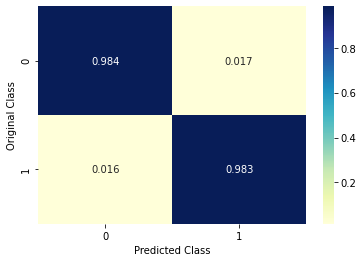

-------------------- Recall matrix (Row sum=1) --------------------


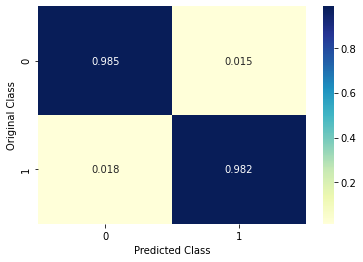

In [74]:
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------

clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(X_train_essay_bow_bi, Y_train,X_cv_essay_bow_bi, Y_cv, clf)

#### Query Point

In [75]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(X_train_essay_bow_bi,Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_essay_bow_bi,Y_train)

test_point_index = 2500

predicted_cls = sig_clf.predict(X_test_essay_bow_bi[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", Y_test[test_point_index])

Predicted Class : 0
Actual Class : 0


#### e.Random Forest Classifier

for n_estimators = 100 and max depth =  5
Log Loss : 0.13010121948629202
for n_estimators = 100 and max depth =  10
Log Loss : 0.0987270942728787
for n_estimators = 200 and max depth =  5
Log Loss : 0.11797348655915435
for n_estimators = 200 and max depth =  10
Log Loss : 0.09252275595652018
for n_estimators = 500 and max depth =  5
Log Loss : 0.11061443050627685
for n_estimators = 500 and max depth =  10
Log Loss : 0.0914393293088195
for n_estimators = 1000 and max depth =  5
Log Loss : 0.1114705014878371
for n_estimators = 1000 and max depth =  10
Log Loss : 0.09112400846158622
for n_estimators = 2000 and max depth =  5
Log Loss : 0.10978214121215614
for n_estimators = 2000 and max depth =  10
Log Loss : 0.091177150357668


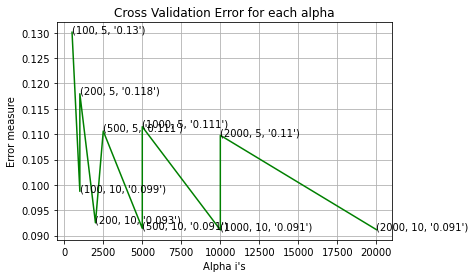

For values of best estimator =  1000 The train log loss is: 0.07226720074853472
For values of best estimator =  1000 The cross validation log loss is: 0.09112400846158622
For values of best estimator =  1000 The test log loss is: 0.09116899661445368


In [16]:
# --------------------------------
# default parameters 
# sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, 
# class_weight=None)

# Some of methods of RandomForestClassifier()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# predict_proba (X)	Perform classification on samples in X.

# some of attributes of  RandomForestClassifier()
# feature_importances_ : array of shape = [n_features]
# The feature importances (the higher, the more important the feature).

# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/random-forest-and-their-construction-2/
# --------------------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------

alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(X_train_essay_bow_bi,Y_train)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(X_train_essay_bow_bi,Y_train)
        sig_clf_probs = sig_clf.predict_proba(X_cv_essay_bow_bi)
        cv_log_error_array.append(log_loss(Y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(Y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/2)],max_depth[int(i%2)],str(txt)), (features[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(X_train_essay_bow_bi,Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_essay_bow_bi,Y_train)

predict_y = sig_clf.predict_proba(X_train_essay_bow_bi)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_cv_essay_bow_bi)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(Y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_essay_bow_bi)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 0.09112400846158622
Number of mis-classified points : 0.03616399717940969
-------------------- Confusion matrix --------------------


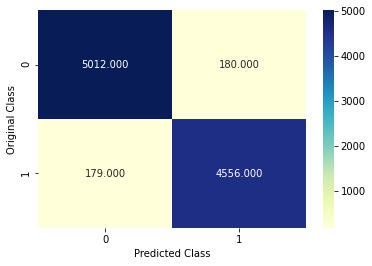

-------------------- Precision matrix (Columm Sum=1) --------------------


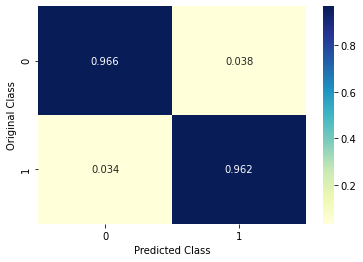

-------------------- Recall matrix (Row sum=1) --------------------


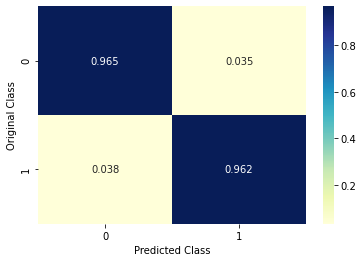

In [21]:
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------

clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], 
                             random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(X_train_essay_bow_bi, Y_train,X_cv_essay_bow_bi, Y_cv, clf)

#### Query Point

In [22]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(X_train_essay_bow_bi,Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_essay_bow_bi,Y_train)

test_point_index = 3456

predicted_cls = sig_clf.predict(X_test_essay_bow_bi[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", Y_test[test_point_index])

Predicted Class : 0
Actual Class : 0


#### f.XGBoost Classifier

log_loss for c =  10 is 0.1464243994192293
log_loss for c =  50 is 0.05778841935486691
log_loss for c =  100 is 0.042773170650672925
log_loss for c =  500 is 0.04377610427597389
log_loss for c =  1000 is 0.04772741342925841
log_loss for c =  2000 is 0.05030522202883841


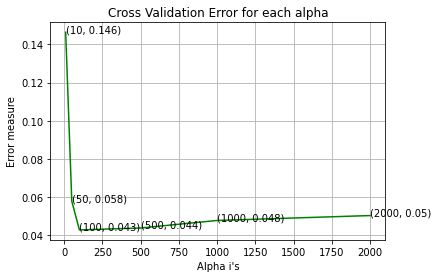

For values of best alpha =  100 The train log loss is: 0.018099311753939275
For values of best alpha =  100 The cross validation log loss is: 0.042773170650672925
For values of best alpha =  100 The test log loss is: 0.050846035752201306


In [23]:
# Training a hyper-parameter tuned Xg-Boost regressor on our train data

# find more about XGBClassifier function here http://xgboost.readthedocs.io/en/latest/python/python_api.html?#xgboost.XGBClassifier
# -------------------------
# default paramters
# class xgboost.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, 
# objective='binary:logistic', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, 
# max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
# scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, **kwargs)

# some of methods of RandomForestRegressor()
# fit(X, y, sample_weight=None, eval_set=None, eval_metric=None, early_stopping_rounds=None, verbose=True, xgb_model=None)
# get_params([deep])	Get parameters for this estimator.
# predict(data, output_margin=False, ntree_limit=0) : Predict with data. NOTE: This function is not thread safe.
# get_score(importance_type='weight') -> get the feature importance
# -----------------------
# video link1: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/regression-using-decision-trees-2/
# video link2: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/what-are-ensembles/
# -----------------------

alpha=[10,50,100,500,1000,2000]
cv_log_error_array=[]
for i in alpha:
    x_cfl=XGBClassifier(n_estimators=i,nthread=-1)
    x_cfl.fit(X_train_essay_bow_bi,Y_train)
    sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
    sig_clf.fit(X_train_essay_bow_bi,Y_train)
    predict_y = sig_clf.predict_proba(X_cv_essay_bow_bi)
    cv_log_error_array.append(log_loss(Y_cv, predict_y, labels=x_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

x_cfl=XGBClassifier(n_estimators=alpha[best_alpha],nthread=-1)
x_cfl.fit(X_train_essay_bow_bi,Y_train)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(X_train_essay_bow_bi,Y_train)
    
predict_y = sig_clf.predict_proba(X_train_essay_bow_bi)
print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_train, predict_y))
predict_y = sig_clf.predict_proba(X_cv_essay_bow_bi)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(Y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test_essay_bow_bi)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_y))

Log loss : 0.042773170650672925
Number of mis-classified points : 0.013599274705349048
-------------------- Confusion matrix --------------------


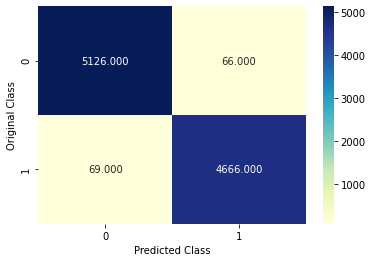

-------------------- Precision matrix (Columm Sum=1) --------------------


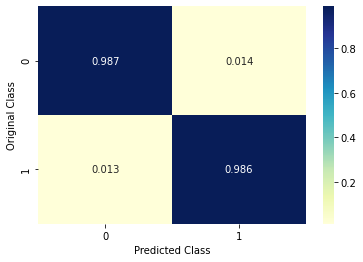

-------------------- Recall matrix (Row sum=1) --------------------


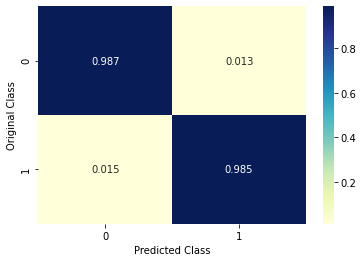

In [24]:
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------

clf = XGBClassifier(n_estimators=alpha[best_alpha],random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(X_train_essay_bow_bi, Y_train,X_cv_essay_bow_bi, Y_cv, clf)

#### XgBoost Classification with best hyper parameters using RandomSearch

In [25]:
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
x_cfl=XGBClassifier()
prams={'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2]}
random_cfl1=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1,)
random_cfl1.fit(X_train_essay_bow_bi,Y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   40.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:  1.8min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:  1.8min remaining:   33.2s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:  2.2min remaining:   14.6s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.2min finished


RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, reg_alpha=None,
                                           reg_lamb

In [26]:
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
x_cfl=XGBClassifier()
prams={'max_depth':[3,5,10]}
random_cfl2=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1,)
random_cfl2.fit(X_train_essay_bow_bi,Y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  15 | elapsed:   17.7s remaining:  1.9min
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:   18.3s remaining:   50.6s
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:   28.1s remaining:   42.1s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:   28.9s remaining:   25.3s
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:   42.9s remaining:   21.4s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:   59.7s remaining:   14.8s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.1min finished


RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, reg_alpha=None,
                                           reg_lamb

In [27]:
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
x_cfl=XGBClassifier()
prams={'n_estimators':[100,200,500,1000,2000]}
random_cfl3=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1,)
random_cfl3.fit(X_train_essay_bow_bi,Y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  13 out of  25 | elapsed:  3.0min remaining:  2.8min
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:  5.9min remaining:  3.3min
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:  7.6min remaining:  2.4min
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed: 11.2min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 12.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 12.5min finished


RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, reg_alpha=None,
                                           reg_lamb

In [28]:
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
x_cfl=XGBClassifier()
prams={'colsample_bytree':[0.1,0.3,0.5,1]}
random_cfl4=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1,)
random_cfl4.fit(X_train_essay_bow_bi,Y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:   17.3s remaining:   25.9s
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:   25.2s remaining:   20.6s
[Parallel(n_jobs=-1)]: Done  14 out of  20 | elapsed:   30.2s remaining:   12.9s
[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed:   42.8s remaining:    7.5s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   46.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   46.2s finished


RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, reg_alpha=None,
                                           reg_lamb

In [29]:
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
x_cfl=XGBClassifier()
prams={'subsample':[0.1,0.3,0.5,1]}
random_cfl5=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1,)
random_cfl5.fit(X_train_essay_bow_bi,Y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:   29.3s remaining:   44.0s
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:   55.8s remaining:   45.7s
[Parallel(n_jobs=-1)]: Done  14 out of  20 | elapsed:   59.9s remaining:   25.6s
[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed:  1.2min remaining:   12.6s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.2min finished


RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, reg_alpha=None,
                                           reg_lamb

In [30]:
print(random_cfl1.best_params_)
print(random_cfl2.best_params_)
print(random_cfl3.best_params_)
print(random_cfl4.best_params_)
print(random_cfl5.best_params_)

{'learning_rate': 0.2}
{'max_depth': 10}
{'n_estimators': 200}
{'colsample_bytree': 0.5}
{'subsample': 1}


train loss 0.010924705364193382
cv loss 0.03926870327660785
test loss 0.046130650846989606
Log loss : 0.03926870327660785
Number of mis-classified points : 0.011685302709781404
-------------------- Confusion matrix --------------------


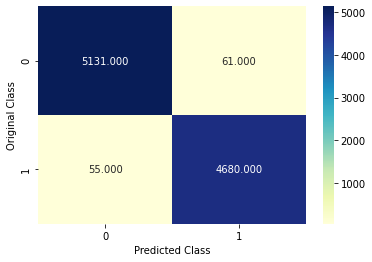

-------------------- Precision matrix (Columm Sum=1) --------------------


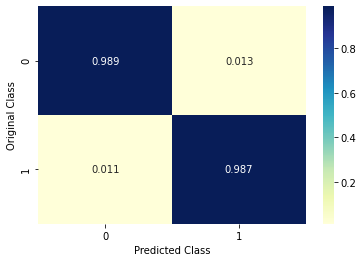

-------------------- Recall matrix (Row sum=1) --------------------


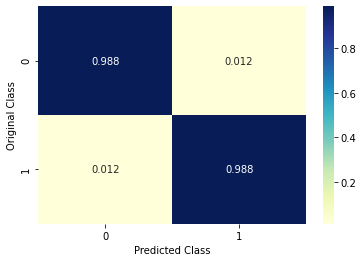

In [31]:
x_cfl=XGBClassifier(n_estimators=200, learning_rate=0.2, colsample_bytree=0.5, max_depth=10,subsample=1)
x_cfl.fit(X_train_essay_bow_bi,Y_train)
c_cfl=CalibratedClassifierCV(x_cfl,method='sigmoid')
c_cfl.fit(X_train_essay_bow_bi,Y_train)

predict_y = c_cfl.predict_proba(X_train_essay_bow_bi)
print ('train loss',log_loss(Y_train, predict_y))
predict_y = c_cfl.predict_proba(X_cv_essay_bow_bi)
print ('cv loss',log_loss(Y_cv, predict_y))
predict_y = c_cfl.predict_proba(X_test_essay_bow_bi)
print ('test loss',log_loss(Y_test, predict_y))
predict_and_plot_confusion_matrix(X_train_essay_bow_bi, Y_train,X_cv_essay_bow_bi, Y_cv, x_cfl)

#### Query Point

In [32]:
clf=XGBClassifier(n_estimators=200, learning_rate=0.2, colsample_bytree=0.5, max_depth=10,subsample=1)
clf.fit(X_train_essay_bow_bi,Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_essay_bow_bi,Y_train)

test_point_index = 4567

predicted_cls = sig_clf.predict(X_test_essay_bow_bi[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", Y_test[test_point_index])

Predicted Class : 0
Actual Class : 0


# c.Applying Tri-grams(n-Grams)

In [14]:
vectorizer = CountVectorizer(ngram_range=(3,3),min_df=10, max_features=5000)
vectorizer.fit(X_train['original'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_bow_n = vectorizer.transform(X_train['original'].values)
X_cv_essay_bow_n = vectorizer.transform(X_cv['original'].values)
X_test_essay_bow_n = vectorizer.transform(X_test['original'].values)

print("After vectorizations")
print("="*100)
print("shape of the matrix of X_train_eassy",X_train_essay_bow_n.shape, Y_train.shape)
print("shape of the matrix of X_cv_eassy",X_cv_essay_bow_n.shape, Y_cv.shape)
print("shape of the matrix of X_test_eassy",X_test_essay_bow_n.shape, Y_test.shape)

After vectorizations
shape of the matrix of X_train_eassy (20154, 5000) (20154,)
shape of the matrix of X_cv_eassy (9927, 5000) (9927,)
shape of the matrix of X_test_eassy (14817, 5000) (14817,)


# Applying ML models

#### a.KNN Classifier

for alpha = 5
Log Loss : 0.512748263147748
for alpha = 11
Log Loss : 0.5588995410017764
for alpha = 15
Log Loss : 0.5760301472942523
for alpha = 21
Log Loss : 0.5922368042602046
for alpha = 31
Log Loss : 0.6097696787749398
for alpha = 41
Log Loss : 0.6207597743629355
for alpha = 51
Log Loss : 0.6277262196892419
for alpha = 99
Log Loss : 0.6438145229196295


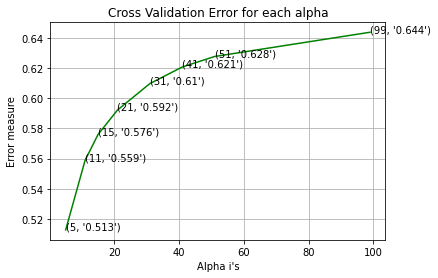

For values of best alpha =  5 The train log loss is: 0.4045390207526994
For values of best alpha =  5 The cross validation log loss is: 0.512748263147748
For values of best alpha =  5 The test log loss is: 0.5290911809161375


In [22]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(X_train_essay_bow_n,Y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_essay_bow_n,Y_train)
    
    sig_clf_probs = sig_clf.predict_proba(X_cv_essay_bow_n)
    cv_log_error_array.append(log_loss(Y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(Y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(X_train_essay_bow_n,Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_essay_bow_n,Y_train)

predict_y = sig_clf.predict_proba(X_train_essay_bow_n)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_cv_essay_bow_n)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(Y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_essay_bow_n)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))


Log loss : 0.512748263147748
Number of mis-classified points : 0.24660018132366274
-------------------- Confusion matrix --------------------


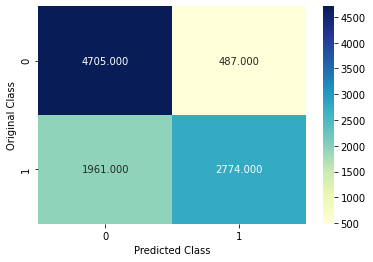

-------------------- Precision matrix (Columm Sum=1) --------------------


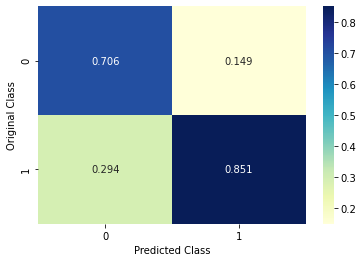

-------------------- Recall matrix (Row sum=1) --------------------


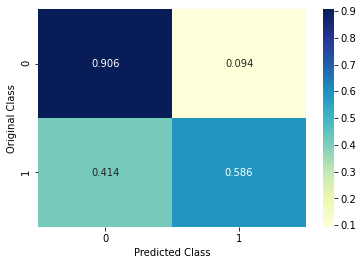

In [23]:
# find more about KNeighborsClassifier() here http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
# -------------------------
# default parameter
# KNeighborsClassifier(n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, p=2, 
# metric=’minkowski’, metric_params=None, n_jobs=1, **kwargs)

# methods of
# fit(X, y) : Fit the model using X as training data and y as target values
# predict(X):Predict the class labels for the provided data
# predict_proba(X):Return probability estimates for the test data X.
#-------------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/k-nearest-neighbors-geometric-intuition-with-a-toy-example-1/
#-------------------------------------
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(X_train_essay_bow_n,Y_train,X_cv_essay_bow_n, Y_cv, clf)

#### Query Point

In [24]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(X_train_essay_bow_n,Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_essay_bow_n,Y_train)

test_point_index = 690

predicted_cls = sig_clf.predict(X_test_essay_bow_n[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", Y_test[test_point_index])
neighbors = clf.kneighbors(X_test_essay_bow_n[test_point_index].reshape(1, -1), alpha[best_alpha])
print("the k value for knn is",alpha[best_alpha],"and the nearest neighbours of the test points belongs to classes",
      Y_train[neighbors[1][0]])
print("Fequency of nearest points :",Counter(Y_train[neighbors[1][0]]))

Predicted Class : 1
Actual Class : 1
the k value for knn is 5 and the nearest neighbours of the test points belongs to classes [1 1 1 0 1]
Fequency of nearest points : Counter({1: 4, 0: 1})


#### b.Naive Bayes

for alpha = 1e-05
Log Loss : 0.13698894431789033
for alpha = 0.0001
Log Loss : 0.13860414374236416
for alpha = 0.001
Log Loss : 0.14095388742173298
for alpha = 0.1
Log Loss : 0.14803289568373382
for alpha = 1
Log Loss : 0.1545351140942425
for alpha = 10
Log Loss : 0.1623422393328697
for alpha = 100
Log Loss : 0.1704241835974334
for alpha = 1000
Log Loss : 0.22177966992998613


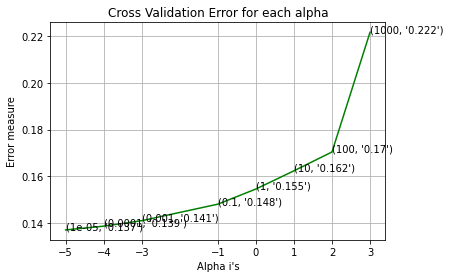

For values of best alpha =  1e-05 The train log loss is: 0.12327874441976165
For values of best alpha =  1e-05 The cross validation log loss is: 0.13698894431789033
For values of best alpha =  1e-05 The test log loss is: 0.14084916493842353


In [25]:
# find more about Multinomial Naive base function here http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
# -------------------------
# default paramters
# sklearn.naive_bayes.MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)

# some of methods of MultinomialNB()
# fit(X, y[, sample_weight])	Fit Naive Bayes classifier according to X, y
# predict(X)	Perform classification on an array of test vectors X.
# predict_log_proba(X)	Return log-probability estimates for the test vector X.
# -----------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/naive-bayes-algorithm-1/
# -----------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
# ----------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/naive-bayes-algorithm-1/
# -----------------------


alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(X_train_essay_bow_n,Y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_essay_bow_n,Y_train)
    sig_clf_probs = sig_clf.predict_proba(X_cv_essay_bow_n)
    cv_log_error_array.append(log_loss(Y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(Y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(X_train_essay_bow_n,Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_essay_bow_n,Y_train)


predict_y = sig_clf.predict_proba(X_train_essay_bow_n)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_cv_essay_bow_n)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(Y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_essay_bow_n)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))


Log loss : 0.13698894431789033
Number of mis-classified points : 0.037977233806789565
-------------------- Confusion matrix --------------------


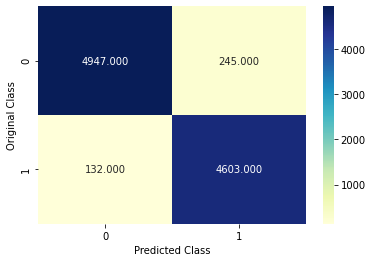

-------------------- Precision matrix (Columm Sum=1) --------------------


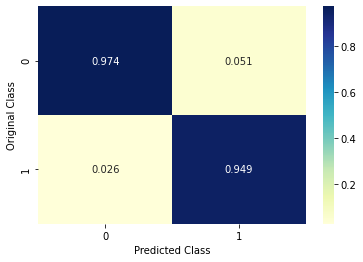

-------------------- Recall matrix (Row sum=1) --------------------


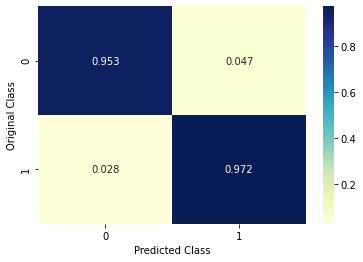

In [26]:
# find more about KNeighborsClassifier() here http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
# -------------------------
# default parameter
# KNeighborsClassifier(n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, p=2, 
# metric=’minkowski’, metric_params=None, n_jobs=1, **kwargs)

# methods of
# fit(X, y) : Fit the model using X as training data and y as target values
# predict(X):Predict the class labels for the provided data
# predict_proba(X):Return probability estimates for the test data X.
#-------------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/k-nearest-neighbors-geometric-intuition-with-a-toy-example-1/
#-------------------------------------
clf = MultinomialNB(alpha=alpha[best_alpha])
predict_and_plot_confusion_matrix(X_train_essay_bow_n,Y_train,X_cv_essay_bow_n, Y_cv, clf)

#### Query Point

In [27]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(X_train_essay_bow_n,Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_essay_bow_n,Y_train)

test_point_index = 3569

predicted_cls = sig_clf.predict(X_test_essay_bow_n[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", Y_test[test_point_index])

Predicted Class : 1
Actual Class : 1


#### c.Logistic Regression

for alpha = 1e-06
Log Loss : 0.12269841844416877
for alpha = 1e-05
Log Loss : 0.117116022364653
for alpha = 0.0001
Log Loss : 0.10639297842444823
for alpha = 0.001
Log Loss : 0.1113652251717769
for alpha = 0.01
Log Loss : 0.1512407770873532
for alpha = 0.1
Log Loss : 0.22766887824378262
for alpha = 1
Log Loss : 0.32600940288364993


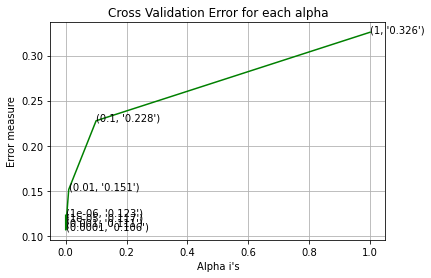

For values of best alpha =  0.0001 The train log loss is: 0.052578637139543055
For values of best alpha =  0.0001 The cross validation log loss is: 0.10639297842444823
For values of best alpha =  0.0001 The test log loss is: 0.11584874186752213


In [28]:
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/geometric-intuition-1/
#------------------------------



# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------

alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train_essay_bow_n,Y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_essay_bow_n,Y_train)
    sig_clf_probs = sig_clf.predict_proba(X_cv_essay_bow_n)
    cv_log_error_array.append(log_loss(Y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(Y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train_essay_bow_n,Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_essay_bow_n,Y_train)

predict_y = sig_clf.predict_proba(X_train_essay_bow_n)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_cv_essay_bow_n)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(Y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_essay_bow_n)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 0.10639297842444823
Number of mis-classified points : 0.036768409388536316
-------------------- Confusion matrix --------------------


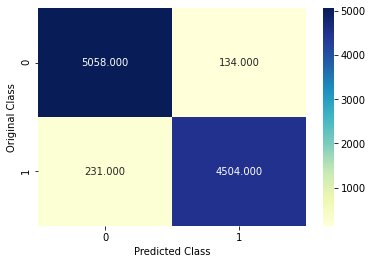

-------------------- Precision matrix (Columm Sum=1) --------------------


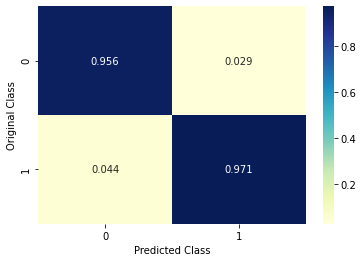

-------------------- Recall matrix (Row sum=1) --------------------


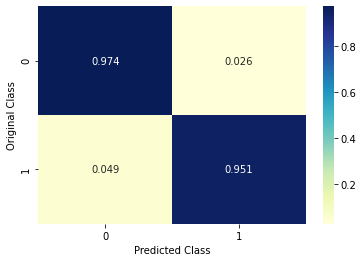

In [29]:
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------

clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(X_train_essay_bow_n, Y_train,X_cv_essay_bow_n, Y_cv, clf)

#### Query Point

In [30]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train_essay_bow_n,Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_essay_bow_n,Y_train)

test_point_index = 4321

predicted_cls = sig_clf.predict(X_test_essay_bow_n[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", Y_test[test_point_index])

Predicted Class : 0
Actual Class : 1


#### d.SVC

for C = 1e-05
Log Loss : 0.12136087578473302
for C = 0.0001
Log Loss : 0.11837143874682877
for C = 0.001
Log Loss : 0.10947805775387441
for C = 0.01
Log Loss : 0.12179575049183727
for C = 0.1
Log Loss : 0.18203236399762776
for C = 1
Log Loss : 0.3377782898288027
for C = 10
Log Loss : 0.37005061668530276
for C = 100
Log Loss : 0.3701741661238651


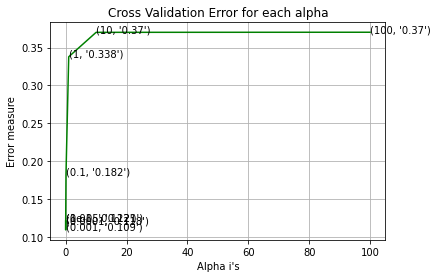

For values of best alpha =  0.001 The train log loss is: 0.06252524936709161
For values of best alpha =  0.001 The cross validation log loss is: 0.10947805775387441
For values of best alpha =  0.001 The test log loss is: 0.1220380804100018


In [31]:
# read more about support vector machines with linear kernals here http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

# --------------------------------
# default parameters 
# SVC(C=1.0, kernel=’rbf’, degree=3, gamma=’auto’, coef0=0.0, shrinking=True, probability=False, tol=0.001, 
# cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=’ovr’, random_state=None)

# Some of methods of SVM()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/mathematical-derivation-copy-8/
# --------------------------------



# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------

alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(X_train_essay_bow_n,Y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_essay_bow_n,Y_train)
    sig_clf_probs = sig_clf.predict_proba(X_cv_essay_bow_n)
    cv_log_error_array.append(log_loss(Y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(Y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(X_train_essay_bow_n,Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_essay_bow_n,Y_train)

predict_y = sig_clf.predict_proba(X_train_essay_bow_n)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_cv_essay_bow_n)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(Y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_essay_bow_n)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 0.10939609544421376
Number of mis-classified points : 0.04089855948423492
-------------------- Confusion matrix --------------------


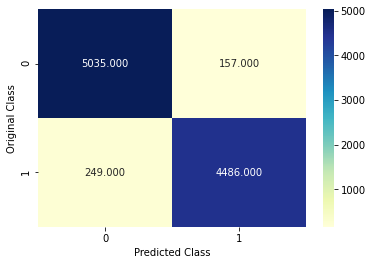

-------------------- Precision matrix (Columm Sum=1) --------------------


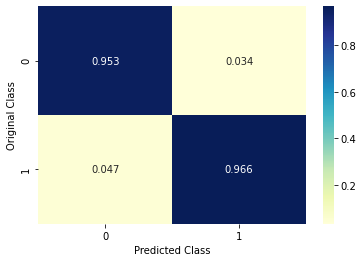

-------------------- Recall matrix (Row sum=1) --------------------


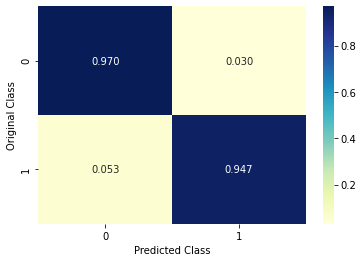

In [32]:
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------

clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(X_train_essay_bow_n, Y_train,X_cv_essay_bow_n, Y_cv, clf)

#### Query Point

In [33]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(X_train_essay_bow_n,Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_essay_bow_n,Y_train)

test_point_index = 569

predicted_cls = sig_clf.predict(X_test_essay_bow_n[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", Y_test[test_point_index])

Predicted Class : 0
Actual Class : 0


#### e.Random Forest Classifier

for n_estimators = 100 and max depth =  5
Log Loss : 0.271119269970317
for n_estimators = 100 and max depth =  10
Log Loss : 0.24599748957840098
for n_estimators = 200 and max depth =  5
Log Loss : 0.25286705322175085
for n_estimators = 200 and max depth =  10
Log Loss : 0.2390914382321689
for n_estimators = 500 and max depth =  5
Log Loss : 0.2535408066033073
for n_estimators = 500 and max depth =  10
Log Loss : 0.23495247400305896
for n_estimators = 1000 and max depth =  5
Log Loss : 0.2464058521653982
for n_estimators = 1000 and max depth =  10
Log Loss : 0.23389843964908014
for n_estimators = 2000 and max depth =  5
Log Loss : 0.2487390276756818
for n_estimators = 2000 and max depth =  10
Log Loss : 0.23530448686793673


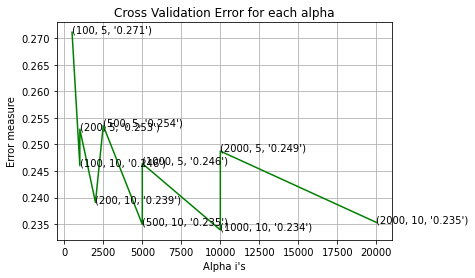

For values of best estimator =  1000 The train log loss is: 0.2182475535433394
For values of best estimator =  1000 The cross validation log loss is: 0.23389843964908014
For values of best estimator =  1000 The test log loss is: 0.23712556919145228


In [34]:
# --------------------------------
# default parameters 
# sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, 
# class_weight=None)

# Some of methods of RandomForestClassifier()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# predict_proba (X)	Perform classification on samples in X.

# some of attributes of  RandomForestClassifier()
# feature_importances_ : array of shape = [n_features]
# The feature importances (the higher, the more important the feature).

# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/random-forest-and-their-construction-2/
# --------------------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------

alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(X_train_essay_bow_n,Y_train)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(X_train_essay_bow_n,Y_train)
        sig_clf_probs = sig_clf.predict_proba(X_cv_essay_bow_n)
        cv_log_error_array.append(log_loss(Y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(Y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/2)],max_depth[int(i%2)],str(txt)), (features[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(X_train_essay_bow_n,Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_essay_bow_n,Y_train)

predict_y = sig_clf.predict_proba(X_train_essay_bow_n)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_cv_essay_bow_n)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(Y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_essay_bow_n)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 0.23389843964908014
Number of mis-classified points : 0.10133978039689735
-------------------- Confusion matrix --------------------


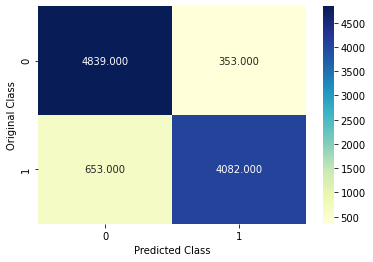

-------------------- Precision matrix (Columm Sum=1) --------------------


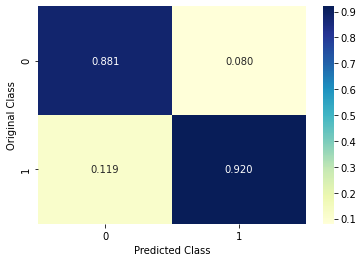

-------------------- Recall matrix (Row sum=1) --------------------


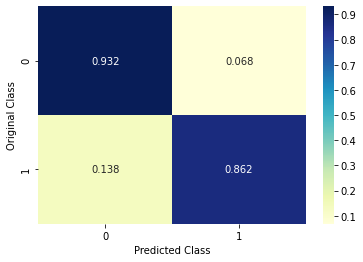

In [35]:
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------

clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], 
                             random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(X_train_essay_bow_n, Y_train,X_cv_essay_bow_n, Y_cv, clf)

#### Query Point

In [36]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(X_train_essay_bow_n,Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_essay_bow_n,Y_train)

test_point_index = 100

predicted_cls = sig_clf.predict(X_test_essay_bow_n[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", Y_test[test_point_index])

Predicted Class : 0
Actual Class : 0


#### f.XGBoost Classifier

log_loss for c =  10 is 0.3257174588617928
log_loss for c =  50 is 0.18524703569250706
log_loss for c =  100 is 0.14437939348181905
log_loss for c =  500 is 0.10741608142095153
log_loss for c =  1000 is 0.11483810780676663
log_loss for c =  2000 is 0.12663390931283378


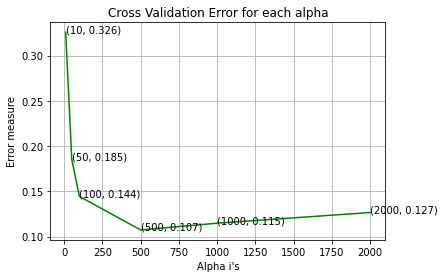

For values of best alpha =  500 The train log loss is: 0.04621996776156302
For values of best alpha =  500 The cross validation log loss is: 0.10741608142095153
For values of best alpha =  500 The test log loss is: 0.10566759067359661


In [37]:
# Training a hyper-parameter tuned Xg-Boost regressor on our train data

# find more about XGBClassifier function here http://xgboost.readthedocs.io/en/latest/python/python_api.html?#xgboost.XGBClassifier
# -------------------------
# default paramters
# class xgboost.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, 
# objective='binary:logistic', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, 
# max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
# scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, **kwargs)

# some of methods of RandomForestRegressor()
# fit(X, y, sample_weight=None, eval_set=None, eval_metric=None, early_stopping_rounds=None, verbose=True, xgb_model=None)
# get_params([deep])	Get parameters for this estimator.
# predict(data, output_margin=False, ntree_limit=0) : Predict with data. NOTE: This function is not thread safe.
# get_score(importance_type='weight') -> get the feature importance
# -----------------------
# video link1: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/regression-using-decision-trees-2/
# video link2: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/what-are-ensembles/
# -----------------------

alpha=[10,50,100,500,1000,2000]
cv_log_error_array=[]
for i in alpha:
    x_cfl=XGBClassifier(n_estimators=i,nthread=-1)
    x_cfl.fit(X_train_essay_bow_n,Y_train)
    sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
    sig_clf.fit(X_train_essay_bow_n,Y_train)
    predict_y = sig_clf.predict_proba(X_cv_essay_bow_n)
    cv_log_error_array.append(log_loss(Y_cv, predict_y, labels=x_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

x_cfl=XGBClassifier(n_estimators=alpha[best_alpha],nthread=-1)
x_cfl.fit(X_train_essay_bow_n,Y_train)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(X_train_essay_bow_n,Y_train)
    
predict_y = sig_clf.predict_proba(X_train_essay_bow_n)
print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_train, predict_y))
predict_y = sig_clf.predict_proba(X_cv_essay_bow_n)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(Y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test_essay_bow_n)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_y))

Log loss : 0.10741608142095153
Number of mis-classified points : 0.037977233806789565
-------------------- Confusion matrix --------------------


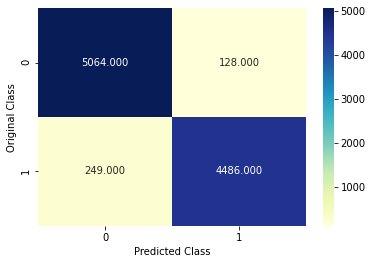

-------------------- Precision matrix (Columm Sum=1) --------------------


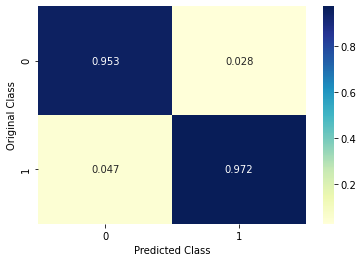

-------------------- Recall matrix (Row sum=1) --------------------


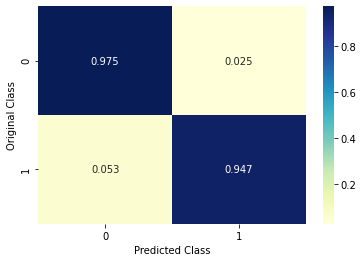

In [38]:
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------

clf = XGBClassifier(n_estimators=alpha[best_alpha],random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(X_train_essay_bow_n, Y_train,X_cv_essay_bow_n, Y_cv, clf)

#### XgBoost Classification with best hyper parameters using RandomSearch

In [39]:
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
x_cfl=XGBClassifier()
prams={'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2]}
random_cfl1=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1,)
random_cfl1.fit(X_train_essay_bow_n,Y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   38.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   51.5s
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:  1.1min remaining:   38.5s
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:  1.1min remaining:   20.4s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:  1.3min remaining:    8.5s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.3min finished


RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, reg_alpha=None,
                                           reg_lamb

In [40]:
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
x_cfl=XGBClassifier()
prams={'max_depth':[3,5,10]}
random_cfl2=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1,)
random_cfl2.fit(X_train_essay_bow_n,Y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  15 | elapsed:    7.6s remaining:   49.7s
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    8.0s remaining:   22.1s
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:   11.8s remaining:   17.7s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:   12.1s remaining:   10.6s
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:   18.7s remaining:    9.3s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:   24.8s remaining:    6.1s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   26.1s finished


RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, reg_alpha=None,
                                           reg_lamb

In [41]:
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
x_cfl=XGBClassifier()
prams={'n_estimators':[100,200,500,1000,2000]}
random_cfl3=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1,)
random_cfl3.fit(X_train_essay_bow_n,Y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   39.8s
[Parallel(n_jobs=-1)]: Done  13 out of  25 | elapsed:  1.3min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:  2.6min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:  3.3min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:  4.7min remaining:   38.2s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  5.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  5.2min finished


RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, reg_alpha=None,
                                           reg_lamb

In [42]:
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
x_cfl=XGBClassifier()
prams={'colsample_bytree':[0.1,0.3,0.5,1]}
random_cfl4=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1,)
random_cfl4.fit(X_train_essay_bow_n,Y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:    7.5s remaining:   11.3s
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:   12.1s remaining:    9.9s
[Parallel(n_jobs=-1)]: Done  14 out of  20 | elapsed:   14.8s remaining:    6.3s
[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed:   21.4s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   22.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   22.1s finished


RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, reg_alpha=None,
                                           reg_lamb

In [43]:
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
x_cfl=XGBClassifier()
prams={'subsample':[0.1,0.3,0.5,1]}
random_cfl5=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1,)
random_cfl5.fit(X_train_essay_bow_n,Y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:   13.7s remaining:   20.6s
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:   24.0s remaining:   19.6s
[Parallel(n_jobs=-1)]: Done  14 out of  20 | elapsed:   26.4s remaining:   11.2s
[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed:   32.5s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   33.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   33.2s finished


RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, reg_alpha=None,
                                           reg_lamb

In [44]:
print(random_cfl1.best_params_)
print(random_cfl2.best_params_)
print(random_cfl3.best_params_)
print(random_cfl4.best_params_)
print(random_cfl5.best_params_)

{'learning_rate': 0.2}
{'max_depth': 10}
{'n_estimators': 500}
{'colsample_bytree': 0.3}
{'subsample': 1}


train loss 0.04529177980624989
cv loss 0.10594081837002806
test loss 0.10516453200708792
Log loss : 0.10594081837002806
Number of mis-classified points : 0.03757429233403848
-------------------- Confusion matrix --------------------


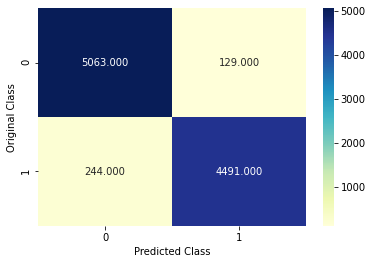

-------------------- Precision matrix (Columm Sum=1) --------------------


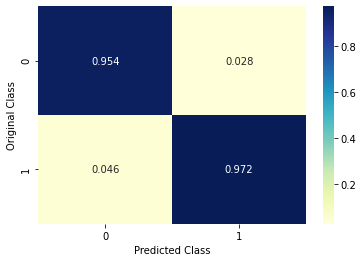

-------------------- Recall matrix (Row sum=1) --------------------


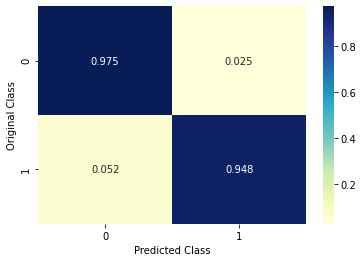

In [45]:
x_cfl=XGBClassifier(n_estimators=500, learning_rate=0.2, colsample_bytree=0.3, max_depth=10,subsample=1)
x_cfl.fit(X_train_essay_bow_n,Y_train)
c_cfl=CalibratedClassifierCV(x_cfl,method='sigmoid')
c_cfl.fit(X_train_essay_bow_n,Y_train)

predict_y = c_cfl.predict_proba(X_train_essay_bow_n)
print ('train loss',log_loss(Y_train, predict_y))
predict_y = c_cfl.predict_proba(X_cv_essay_bow_n)
print ('cv loss',log_loss(Y_cv, predict_y))
predict_y = c_cfl.predict_proba(X_test_essay_bow_n)
print ('test loss',log_loss(Y_test, predict_y))
predict_and_plot_confusion_matrix(X_train_essay_bow_n, Y_train,X_cv_essay_bow_n, Y_cv, x_cfl)

#### Query Point

In [46]:
clf =XGBClassifier(n_estimators=500, learning_rate=0.2, colsample_bytree=0.3, max_depth=10,subsample=1)
clf.fit(X_train_essay_bow_n,Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_essay_bow_n,Y_train)

test_point_index = 789

predicted_cls = sig_clf.predict(X_test_essay_bow_n[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", Y_test[test_point_index])

Predicted Class : 1
Actual Class : 0
